In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import regex
import emoji
from pycountry import languages
import fasttext

In [2]:
reviews_raw = pd.read_csv("/Users/abhik_bhattacharjee/Desktop/MSc CS IS SEM 1/Machine Learning/Final Assignment/Data/reviews.csv")

In [3]:
def split_count(info):

    emoji_list = []
    data = regex.findall(r'\X', info)
    for word in data:
        if any(char in emoji.EMOJI_DATA for char in word):
            emoji_list.append(word)

    return len(emoji_list)

In [4]:
PRETRAINED_MODEL_PATH = '/Users/abhik_bhattacharjee/Downloads/lid.176.bin'
model = fasttext.load_model(PRETRAINED_MODEL_PATH)

In [5]:
reviews_raw['lang'] = range(0, len(reviews_raw))

for index, row in reviews_raw.iterrows():
    if type(row['comments']) == type('s'):
      predictions = model.predict(row['comments'])
      l = predictions[0][0].split('_label_')[1]
      if l != 'ceb' and l != 'nds' and l != 'war' and l != 'wuu':
          reviews_raw['lang'][index] = l

In [6]:
reviews_raw = reviews_raw[reviews_raw['comments'].notna()]

In [7]:
reviews_raw['emoji_count'] = reviews_raw.comments.apply(split_count)

reviews_raw['lenstr'] = reviews_raw['comments'].str.len()

reviews_raw['test_emoji'] = (((reviews_raw['emoji_count'] == reviews_raw['lenstr']) |
                          (2*reviews_raw['emoji_count'] == reviews_raw['lenstr'])) & (reviews_raw['emoji_count']!=0))

In [8]:
reviews_raw = reviews_raw[reviews_raw.test_emoji == False]

reviews_raw = reviews_raw.drop(columns='test_emoji')
reviews_raw = reviews_raw.drop(columns='lenstr')
reviews_raw = reviews_raw.drop(columns='emoji_count')

In [9]:
reviews_raw.comments = reviews_raw.comments.apply(lambda x: x.encode('ascii', 'ignore').decode('ascii'))
reviews_raw['emoji_count'] = reviews_raw.comments.apply(split_count)

In [10]:
reviews_raw = reviews_raw[(reviews_raw.comments.str.len() > 20)]
reviews_raw['comments'] = reviews_raw['comments'].str.replace('<br/>', '')

In [11]:
reviews_raw = reviews_raw[reviews_raw.lang == '_en']

In [12]:
reviews_raw.to_csv("/Users/abhik_bhattacharjee/Desktop/MSc CS IS SEM 1/Machine Learning/Final Assignment/Data/reviews_cleansed.csv")

In [13]:
reviews = pd.read_csv("/Users/abhik_bhattacharjee/Desktop/MSc CS IS SEM 1/Machine Learning/Final Assignment/Data/reviews_cleansed.csv",
                      lineterminator='\n')

Mean:  44.73930010131516
Median:  33.0


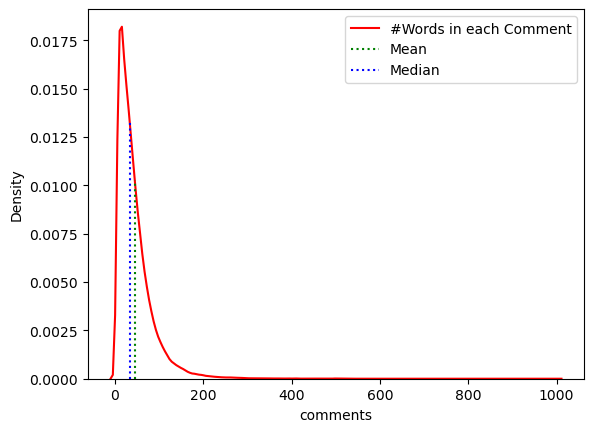

In [14]:
print("Mean: ", reviews['comments'].str.split().str.len().mean())
print("Median: ", reviews['comments'].str.split().str.len().median())
i = sns.kdeplot(reviews['comments'].str.split().str.len(),color="r", label='#Words in each Comment')
xi = i.lines[0].get_xdata()
yi = i.lines[0].get_ydata()
meani = reviews['comments'].str.split().str.len().mean()
mediani = reviews['comments'].str.split().str.len().median()
heighti = np.interp(meani, xi, yi)
heighti2 = np.interp(mediani, xi, yi)
i.vlines(meani, 0, heighti, color='g', ls=':', label='Mean')
i.vlines(mediani, 0, heighti2, color='b', ls=':', label='Median')
plt.legend()
plt.show()

In [15]:
stop = stopwords.words('english')
reviews['comments_stp_rem'] = reviews['comments'].apply(lambda x: ' '.join([word.lower() for word in x.split() 
                                                                 if word not in (stop)]))

In [16]:
tr_idf_model  = TfidfVectorizer(analyzer = 'word', max_features=33)
tf_idf_vector = tr_idf_model.fit_transform(reviews.comments_stp_rem)

In [17]:
tf_idf_array = tf_idf_vector.toarray()

In [18]:
words_set = tr_idf_model.get_feature_names()

In [19]:
df_tf_idf = pd.DataFrame(tf_idf_array, columns = words_set)

In [20]:
df_tf_idf['listing_id'] = reviews.listing_id

In [21]:
test = df_tf_idf.groupby('listing_id').size()
review_1 = pd.DataFrame({'listing_id':test.index, 'num_cmt':test.values})

In [22]:
test2 = pd.DataFrame([])
for i in words_set:
        test2[f'term_{i}'] = df_tf_idf.groupby(['listing_id'])[f'{i}'].mean()

In [23]:
review_final = review_1.merge(test2, on='listing_id')

review_final.to_csv("/Users/abhik_bhattacharjee/Desktop/MSc CS IS SEM 1/Machine Learning/Final Assignment/Data/review_final_tfidf.csv")